## Modules Importing
Import all necessary modules and add PyGRANSO src folder to system path. 

In [2]:
import time
import torch
import sys
## Adding PyGRANSO directories. Should be modified by user
sys.path.append('.')
from pygranso.pygranso import pygranso
from pygranso.pygransoStruct import pygransoStruct 
from pygranso.private.getNvar import getNvarTorch
import torch.nn as nn
# from torchvision import datasets
# from torchvision.transforms import ToTensor
# from pygranso.private.getObjGrad import getObjGradDL

import scipy
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import torch
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# fix the random seed
torch.manual_seed(55272025)
pass

# w = 8

## Model architecture

In [27]:
class PINN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(PINN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.linear_in = nn.Linear(input_size, hidden_size)
        self.linear_hidden = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for i in range(num_layers - 1)])
        self.linear_out = nn.Linear(hidden_size, 1)
        self.activ = nn.Tanh()
        
    def forward(self, x):
        x = self.linear_in(x)
        x = self.activ(x)
        for l in self.linear_hidden:
            x = l(x)
            x = self.activ(x)
        out = self.linear_out(x)
        return out
    
def get_grads(u, x, t):
    u_t = torch.autograd.grad(
        u, t,
        grad_outputs=torch.ones_like(u),
        retain_graph=True,
        create_graph=True
    )[0]

    u_x = torch.autograd.grad(
        u, x,
        grad_outputs=torch.ones_like(u),
        retain_graph=True,
        create_graph=True
    )[0]

    u_xx = torch.autograd.grad(
        u_x, x,
        grad_outputs=torch.ones_like(u_x),
        retain_graph=True,
        create_graph=True
    )[0]

    return u_t,u_x,u_xx

## Data setup

In [28]:
###
### START data setup
double_precision = torch.double
data = scipy.io.loadmat('./data/burgers_shock.mat')

# Get boundary points along three sides (x = -1, x = 1, t = 0)
tb_x = data['t']
xb_t = data['x']
xb_xlow = np.full_like(tb_x, data['x'][0])
xb_xhigh = np.full_like(tb_x, data['x'][-1])
tb_tlow = np.full_like(xb_t, data['t'][0])

usol_xlow = data['usol'][0,:,None]
usol_xhigh = data['usol'][-1,:,None]
usol_tlow = data['usol'][:,0,None]

xb = np.vstack((xb_xlow, xb_xhigh, xb_t))
tb = np.vstack((tb_x, tb_x, tb_tlow))
usolb = np.vstack((usol_xlow, usol_xhigh, usol_tlow))

xb = torch.Tensor(xb).to(device=device, dtype=double_precision).requires_grad_()
tb = torch.Tensor(tb).to(device=device, dtype=double_precision).requires_grad_()
usolb = torch.Tensor(usolb).to(device=device, dtype=double_precision).requires_grad_()

# boundary_usol = usolb # point this global var at the right place

boundary_points = (xb, tb)

# Ground-truth data - used for testing/evaluation
usol_full = data['usol']
usol_tensor = usol_full.flatten()
usol_tensor = torch.Tensor(usol_tensor).to(device=device, dtype=double_precision)

# Sample points. Following Dual-Cone Gradient Descent, 10x as many sample points as boundary points
n_samples = 4560
xs = -1 + 2 * np.random.rand(n_samples, 1)
ts = np.random.rand(n_samples, 1)

xs = torch.Tensor(xs).to(device=device, dtype=double_precision).requires_grad_()
ts = torch.Tensor(ts).to(device=device, dtype=double_precision).requires_grad_()
sample_points = (xs, ts)

# Create grid inputs for visualization, comparison to GT
xgridsize = 256
tgridsize = 100
tv, xv = np.meshgrid(data['t'], data['x'])
tv = torch.Tensor(tv.flatten()).to(device=device, dtype=double_precision).requires_grad_()
xv = torch.Tensor(xv.flatten()).to(device=device, dtype=double_precision).requires_grad_()
grid_points = torch.stack((xv, tv)).transpose(0,1)
### END data setup
###

# Evaluates the relative L2 error over all grid points
# Notably, this is NOT what the PINN is minimizing--it only has access to boundary points
def evaluate(iteration, model, xv, tv, test_usol, error):
    test_points = torch.stack((xv, tv)).transpose(0,1)
    pred_usol = model(test_points)
    L2_error = torch.norm(pred_usol - test_usol)
    error[iteration-1] = L2_error.cpu().detach().item()

    # Save intermediate results (NN outputs + PDE residuals) as images
    if iteration % 25 == 0:
        outimg = pred_usol.cpu().detach().numpy()
        outimg = np.reshape(outimg, (xgridsize, tgridsize))
        plt.imsave("output_imgs/predicted_"+str(iteration)+".png", outimg, origin='upper')
        plt.close()
        evalu_t, evalu_x, evalu_xx = get_grads(pred_usol, xv, tv)
        evalres = evalu_t + torch.flatten(pred_usol) * evalu_x - 0.01 / np.pi * evalu_xx
        outimg = evalres.cpu().detach().numpy()
        outimg = np.reshape(outimg, (xgridsize, tgridsize))
        plt.imsave("output_imgs/pderesidual_"+str(iteration)+".png", outimg, vmin=-3, vmax=3, origin='upper')
        plt.close()

# Exact Penalty with PyGRANSO

In [29]:
train_acc = []
test_acc = []

In [39]:
def f(model, sample_points): # objective
    x, t = sample_points
    xt = torch.cat((x, t), 1)
    u = model(xt)
    
    # Calculate gradients of network
    u_t, u_x, u_xx = get_grads(u, x, t)
    
    # Minimize residual
    res = u_t + u * u_x - 0.01 / np.pi * u_xx
    # objective = torch.norm(res)
    
    objective = torch.norm(res) / res.numel() # TODO: try normalizing loss
    return objective

def penalty(model, boundary_points, boundary_usol):
    xb, tb = boundary_points
    xtb = torch.cat((xb, tb), 1)
    ub = model(xtb)    
    boundary_errors = ub - boundary_usol
    # return torch.norm(boundary_errors, p=1)
    return torch.norm(boundary_errors, p=1) / boundary_errors.numel() # TODO: try normalizing loss

def l2_penalty(model, boundary_points, boundary_usol):
    xb, tb = boundary_points
    xtb = torch.cat((xb, tb), 1)
    ub = model(xtb)
    
    boundary_errors = ub - boundary_usol
#     return torch.norm(boundary_errors, p=2)
    return torch.norm(boundary_errors, p=2) / boundary_errors.numel() # TODO: try

# explicitly takes following arguments:
# sample_points: Tensor(2, n_sample_points)
# boundary_points: Tensor(2, n_boundary_points)
# boundary_usol: Tensor(n_boundary_points)
# def phi1(model, mu, sample_points, boundary_points, boundary_usol):
#     return f(model, sample_points) + mu * penalty(model, boundary_points, boundary_usol)

In [40]:
# Adam stuff

# def train_loop(model, mu, optimizer):
#     model.train()
    
#     loss = phi1(model, mu)

#     loss.backward()
#     optimizer.step()
#     optimizer.zero_grad()

# def val_loop(dataloader, model):
#     model.eval()
#     # size = len(dataloader.dataset)
#     size = batch_size
#     correct = 0

#     with torch.no_grad():
#         logits = model(inputs)
#         _, predicted = torch.max(logits.data, 1)
#         train_acc.append((predicted == labels).sum().item() / size)
        
#         logits = model(test_inputs)
#         _, predicted = torch.max(logits.data, 1)
#         c = (predicted == test_labels).sum().item()
#         test_acc.append(c / size)
#         correct += c
    
#     correct /= size
#     print(f"Error: \n Accuracy: {(100*correct):>0.1f}% \n")
#     return 100*correct

### 1000 inner epochs

In [49]:
# `f_lambda` takes form `lambda model: loss_of_model_on_training_set`
# `penalty_lambda` takes form `lambda model: penalty_of_model`
# these two lambdas should have other required info (e.g. training points) already baked into them
def exact_penalty_with_pygranso(model, f_lambda, penalty_lambda, mu_0=1., mu_rho=1.1, mu_eps=1e-5, n_inner_iters=1000, max_iters=100):
    mu = torch.tensor([mu_0], dtype=double_precision).to(device)
    h_prev = float('inf')

    # for iteration in range(1000):
    for iteration in range(max_iters): # TODO: try smaller number of iterations (e.g. 2), and/or try Wenjie stopping strategy
        print("Iter", iteration)
        
        # PyGRANSO
        def comb_fn(model):
            # objective function
            # phi1_x_mu = phi1(model, mu, sample_points, boundary_points, boundary_usol)
            phi1_x_mu = f_lambda(model) + mu * penalty_lambda(model)
        
            # inequality constraint, matrix form
            ci = None
        
            # equality constraint 
            ce = None
        
            return [phi1_x_mu,ci,ce]
        
        opts = pygransoStruct()
        # option for switching QP solver. We only have osqp as the only qp solver in current version. Default is osqp
        # opts.QPsolver = 'osqp'
        
        # set an intial point
        # All the user-provided data (vector/matrix/tensor) must be in torch tensor format. 
        # As PyTorch tensor is single precision by default, one must explicitly set `dtype=torch.double`.
        # Also, please make sure the device of provided torch tensor is the same as opts.torch_device.
        nvar = getNvarTorch(model.parameters())
        opts.x0 = torch.nn.utils.parameters_to_vector(model.parameters()).detach().reshape(nvar,1)
        opts.torch_device = device
        opts.opt_tol = 1e-11
        opts.viol_eq_tol = 1e-8
        opts.print_level = 1
        opts.print_frequency = 50
        opts.maxit = n_inner_iters  # Inner epochs # TODO: perhaps tune
        opts.disable_terminationcode_6 = True # Important for training NNs
        
        start = time.time()
        soln = pygranso(var_spec = model,combined_fn = comb_fn, user_opts = opts)
        end = time.time()
        print("Total Wall Time: {}s".format(end - start))
        torch.nn.utils.vector_to_parameters(soln.final.x, model.parameters())
        
        # Exact penalty update
        
        h = penalty_lambda(model)
        print("Objective:", f_lambda(model))
        print("Penalty parameter:", mu)
        print("Penalty:", h)
        if h < 1e-5:  # if h(xk ) ≤ τ
            break

        # Choose new penalty parameter µk+1 > µk ;
        if h > mu_eps:
            mu *= mu_rho

        # Choose new starting point (stay as optimal x1, x2)

        print()

In [50]:
if __name__ == "__main__":
    # NN hyperparams - width + depth are somewhat arbitrary and vary between papers
    input_size = 2
    hidden_size = 20
    num_layers = 7
    double_precision = torch.double

    # Create PINN
    torch.manual_seed(552720250)
    model = PINN(input_size, hidden_size, num_layers).to(device=device, dtype=double_precision)
    model.train()

    # Tensors have fixed size and we need to modify in-place, so initialize with maximum possible size
    max_iters = 200
    error = torch.empty(max_iters, device=device, dtype=double_precision)
   
    f_lambda = lambda model: f(model, sample_points)#*4560   
    penalty_lambda = lambda model: penalty(model, boundary_points, boundary_usol=usolb)#*4560

    exact_penalty_with_pygranso(
        model,
        mu_0=0.1,
        mu_rho=1.1,
        mu_eps=1e-5,
        f_lambda=f_lambda,
        penalty_lambda=penalty_lambda,
        n_inner_iters=1000,
        max_iters=100,
    )
    
    

Iter 0


╔═════ QP SOLVER NOTICE ════════════════════════════════════════════════════════════════════════╗
║  PyGRANSO requires a quadratic program (QP) solver that has a quadprog-compatible interface,  ║
║  the default is osqp. Users may provide their own wrapper for the QP solver.                  ║
║  To disable this notice, set opts.quadprog_info_msg = False                                   ║
╚═══════════════════════════════════════════════════════════════════════════════════════════════╝
══════════════════════════════════════════════════════════════════════════════════════════════╗
PyGRANSO: A PyTorch-enabled port of GRANSO with auto-differentiation                          ║ 
Version 1.2.0                                                                                 ║ 
Licensed under the AGPLv3, Copyright (C) 2021-2022 Tim Mitchell and Buyun Liang               ║ 
══════════════════════════════════════════════════════════════════════════════════════════════╣
Problem specificat

 450 ║  - │   -   ║  1.2054298e-04 ║   -  │   -  ║ QN │     1 │ 1.000000 ║     6 │ 1.65e-05   ║ 
 500 ║  - │   -   ║  1.2041381e-04 ║   -  │   -  ║ QN │     1 │ 1.000000 ║     3 │ 7.94e-06   ║ 
 550 ║  - │   -   ║  1.2028599e-04 ║   -  │   -  ║ QN │     1 │ 1.000000 ║     5 │ 2.12e-05   ║ 
 600 ║  - │   -   ║  1.2021162e-04 ║   -  │   -  ║ QN │     1 │ 1.000000 ║     1 │ 1.25e-04   ║ 
 650 ║  - │   -   ║  1.2000272e-04 ║   -  │   -  ║ QN │     1 │ 1.000000 ║     2 │ 2.34e-05   ║ 
 700 ║  - │   -   ║  1.1990615e-04 ║   -  │   -  ║ QN │     1 │ 1.000000 ║     2 │ 6.85e-05   ║ 
 750 ║  - │   -   ║  1.1977852e-04 ║   -  │   -  ║ QN │     1 │ 1.000000 ║     3 │ 5.57e-06   ║ 
 800 ║  - │   -   ║  1.1963345e-04 ║   -  │   -  ║ QN │     1 │ 1.000000 ║     1 │ 5.32e-05   ║ 
 850 ║  - │   -   ║  1.1951764e-04 ║   -  │   -  ║ QN │     1 │ 1.000000 ║     7 │ 9.90e-06   ║ 
 900 ║  - │   -   ║  1.1939081e-04 ║   -  │   -  ║ QN │     1 │ 1.000000 ║     5 │ 1.77e-05   ║ 
 950 ║  - │   -   ║  1.1928276

  50 ║  - │   -   ║  1.2170574e-04 ║   -  │   -  ║ QN │     1 │ 1.000000 ║     1 │ 3.60e-06   ║ 
 100 ║  - │   -   ║  1.2169430e-04 ║   -  │   -  ║ QN │     2 │ 2.000000 ║     1 │ 3.22e-06   ║ 
 150 ║  - │   -   ║  1.2168424e-04 ║   -  │   -  ║ QN │     2 │ 0.500000 ║    32 │ 1.57e-07   ║ 
 200 ║  - │   -   ║  1.2167045e-04 ║   -  │   -  ║ QN │     1 │ 1.000000 ║    34 │ 3.54e-07   ║ 
 250 ║  - │   -   ║  1.2164480e-04 ║   -  │   -  ║ QN │     1 │ 1.000000 ║     7 │ 2.74e-06   ║ 
 300 ║  - │   -   ║  1.2162600e-04 ║   -  │   -  ║ QN │     2 │ 2.000000 ║    19 │ 2.39e-06   ║ 
 350 ║  - │   -   ║  1.2160822e-04 ║   -  │   -  ║ QN │     1 │ 1.000000 ║    13 │ 5.50e-06   ║ 
 400 ║  - │   -   ║  1.2157758e-04 ║   -  │   -  ║ QN │     1 │ 1.000000 ║    10 │ 4.78e-06   ║ 
 450 ║  - │   -   ║  1.2156188e-04 ║   -  │   -  ║ QN │     2 │ 2.000000 ║     5 │ 3.58e-06   ║ 
 500 ║  - │   -   ║  1.2153595e-04 ║   -  │   -  ║ QN │     1 │ 1.000000 ║    15 │ 4.34e-07   ║ 
 550 ║  - │   -   ║  1.2153100

  50 ║  - │   -   ║  1.2442103e-04 ║   -  │   -  ║ QN │     4 │ 0.125000 ║     1 │ 1.10e-07   ║ 
 100 ║  - │   -   ║  1.2441299e-04 ║   -  │   -  ║ QN │     4 │ 8.000000 ║     1 │ 2.22e-07   ║ 
 150 ║  - │   -   ║  1.2440579e-04 ║   -  │   -  ║ QN │     3 │ 0.250000 ║    51 │ 6.89e-08   ║ 
 200 ║  - │   -   ║  1.2440333e-04 ║   -  │   -  ║ QN │     3 │ 4.000000 ║    81 │ 9.63e-08   ║ 
 250 ║  - │   -   ║  1.2439738e-04 ║   -  │   -  ║ QN │     2 │ 2.000000 ║    55 │ 1.99e-07   ║ 
 300 ║  - │   -   ║  1.2439493e-04 ║   -  │   -  ║ QN │     1 │ 1.000000 ║    74 │ 2.65e-07   ║ 
 350 ║  - │   -   ║  1.2439081e-04 ║   -  │   -  ║ QN │     1 │ 1.000000 ║    73 │ 1.80e-07   ║ 
 400 ║  - │   -   ║  1.2438779e-04 ║   -  │   -  ║ QN │     1 │ 1.000000 ║    62 │ 1.13e-07   ║ 
 450 ║  - │   -   ║  1.2438411e-04 ║   -  │   -  ║ QN │     1 │ 1.000000 ║    70 │ 6.25e-07   ║ 
 500 ║  - │   -   ║  1.2438116e-04 ║   -  │   -  ║ QN │     2 │ 2.000000 ║    57 │ 8.45e-07   ║ 
 550 ║  - │   -   ║  1.2437538

  50 ║  - │   -   ║  1.2867735e-04 ║   -  │   -  ║ QN │     1 │ 1.000000 ║     1 │ 1.43e-07   ║ 
 100 ║  - │   -   ║  1.2867303e-04 ║   -  │   -  ║ QN │     1 │ 1.000000 ║     1 │ 1.30e-07   ║ 
 150 ║  - │   -   ║  1.2866837e-04 ║   -  │   -  ║ QN │     2 │ 2.000000 ║    51 │ 1.42e-07   ║ 
 200 ║  - │   -   ║  1.2865855e-04 ║   -  │   -  ║ QN │     1 │ 1.000000 ║    33 │ 3.42e-07   ║ 
 250 ║  - │   -   ║  1.2865389e-04 ║   -  │   -  ║ QN │     1 │ 1.000000 ║    61 │ 3.04e-07   ║ 
 300 ║  - │   -   ║  1.2864917e-04 ║   -  │   -  ║ QN │     1 │ 1.000000 ║    48 │ 2.41e-07   ║ 
 350 ║  - │   -   ║  1.2864363e-04 ║   -  │   -  ║ QN │     4 │ 0.125000 ║    54 │ 7.60e-07   ║ 
 400 ║  - │   -   ║  1.2864049e-04 ║   -  │   -  ║ QN │     1 │ 1.000000 ║    61 │ 7.03e-07   ║ 
 450 ║  - │   -   ║  1.2863413e-04 ║   -  │   -  ║ QN │     2 │ 0.500000 ║    48 │ 2.02e-07   ║ 
 500 ║  - │   -   ║  1.2863101e-04 ║   -  │   -  ║ QN │     1 │ 1.000000 ║    69 │ 1.72e-07   ║ 
 550 ║  - │   -   ║  1.2862872

  50 ║  - │   -   ║  1.3390475e-04 ║   -  │   -  ║ QN │     1 │ 1.000000 ║     1 │ 2.00e-10   ║ 
 100 ║  - │   -   ║  1.3390434e-04 ║   -  │   -  ║ QN │     3 │ 4.000000 ║     1 │ 4.06e-09   ║ 
 150 ║  - │   -   ║  1.3390405e-04 ║   -  │   -  ║ QN │     1 │ 1.000000 ║    51 │ 1.34e-09   ║ 
 200 ║  - │   -   ║  1.3390366e-04 ║   -  │   -  ║ QN │     1 │ 1.000000 ║   100 │ 1.60e-09   ║ 
 250 ║  - │   -   ║  1.3390353e-04 ║   -  │   -  ║ QN │     4 │ 8.000000 ║   100 │ 1.74e-09   ║ 
 300 ║  - │   -   ║  1.3390295e-04 ║   -  │   -  ║ QN │     2 │ 0.500000 ║   100 │ 7.95e-08   ║ 
 350 ║  - │   -   ║  1.3390263e-04 ║   -  │   -  ║ QN │     1 │ 1.000000 ║   100 │ 8.02e-10   ║ 
 400 ║  - │   -   ║  1.3390248e-04 ║   -  │   -  ║ QN │     1 │ 1.000000 ║   100 │ 2.16e-09   ║ 
 450 ║  - │   -   ║  1.3390206e-04 ║   -  │   -  ║ QN │     1 │ 1.000000 ║   100 │ 5.96e-10   ║ 
 500 ║  - │   -   ║  1.3390182e-04 ║   -  │   -  ║ QN │     1 │ 1.000000 ║   100 │ 1.89e-07   ║ 
 550 ║  - │   -   ║  1.3390096

═════╩════════════╩════════════════╩═════════════╩═══════════════════════╩════════════════════╣
F = final iterate, B = Best (to tolerance), MF = Most Feasible                                ║ 
Optimization results:                                                                         ║ 
═════╦════════════╦════════════════╦═════════════╦═══════════════════════╦════════════════════╣
   F ║    │       ║  1.4037003e-04 ║   -  │   -  ║    │       │          ║       │            ║ 
   B ║    │       ║  1.4037003e-04 ║   -  │   -  ║    │       │          ║       │            ║ 
═════╩════════════╩════════════════╩═════════════╩═══════════════════════╩════════════════════╣
Iterations:              2                                                                    ║ 
Function evaluations:    33                                                                   ║ 
PyGRANSO termination code: 0 --- converged to stationarity tolerance.                         ║ 
═════════════════════════════════

═════╩════════════╩════════════════╩═════════════╩═══════════════════════╩════════════════════╣
F = final iterate, B = Best (to tolerance), MF = Most Feasible                                ║ 
Optimization results:                                                                         ║ 
═════╦════════════╦════════════════╦═════════════╦═══════════════════════╦════════════════════╣
   F ║    │       ║  1.5271458e-04 ║   -  │   -  ║    │       │          ║       │            ║ 
   B ║    │       ║  1.5271458e-04 ║   -  │   -  ║    │       │          ║       │            ║ 
═════╩════════════╩════════════════╩═════════════╩═══════════════════════╩════════════════════╣
Iterations:              0                                                                    ║ 
Function evaluations:    32                                                                   ║ 
PyGRANSO termination code: 6 --- line search bracketed a minimizer but failed to satisfy      ║ 
Wolfe conditions.  This may be an

═════╩════════════╩════════════════╩═════════════╩═══════════════════════╩════════════════════╣
F = final iterate, B = Best (to tolerance), MF = Most Feasible                                ║ 
Optimization results:                                                                         ║ 
═════╦════════════╦════════════════╦═════════════╦═══════════════════════╦════════════════════╣
   F ║    │       ║  1.6914517e-04 ║   -  │   -  ║    │       │          ║       │            ║ 
   B ║    │       ║  1.6914517e-04 ║   -  │   -  ║    │       │          ║       │            ║ 
═════╩════════════╩════════════════╩═════════════╩═══════════════════════╩════════════════════╣
Iterations:              2                                                                    ║ 
Function evaluations:    34                                                                   ║ 
PyGRANSO termination code: 0 --- converged to stationarity tolerance.                         ║ 
═════════════════════════════════

═════╩════════════╩════════════════╩═════════════╩═══════════════════════╩════════════════════╣
F = final iterate, B = Best (to tolerance), MF = Most Feasible                                ║ 
Optimization results:                                                                         ║ 
═════╦════════════╦════════════════╦═════════════╦═══════════════════════╦════════════════════╣
   F ║    │       ║  1.9101429e-04 ║   -  │   -  ║    │       │          ║       │            ║ 
   B ║    │       ║  1.9101429e-04 ║   -  │   -  ║    │       │          ║       │            ║ 
═════╩════════════╩════════════════╩═════════════╩═══════════════════════╩════════════════════╣
Iterations:              0                                                                    ║ 
Function evaluations:    32                                                                   ║ 
PyGRANSO termination code: 6 --- line search bracketed a minimizer but failed to satisfy      ║ 
Wolfe conditions.  This may be an

═════╩════════════╩════════════════╩═════════════╩═══════════════════════╩════════════════════╣
F = final iterate, B = Best (to tolerance), MF = Most Feasible                                ║ 
Optimization results:                                                                         ║ 
═════╦════════════╦════════════════╦═════════════╦═══════════════════════╦════════════════════╣
   F ║    │       ║  2.2012209e-04 ║   -  │   -  ║    │       │          ║       │            ║ 
   B ║    │       ║  2.2012209e-04 ║   -  │   -  ║    │       │          ║       │            ║ 
═════╩════════════╩════════════════╩═════════════╩═══════════════════════╩════════════════════╣
Iterations:              0                                                                    ║ 
Function evaluations:    33                                                                   ║ 
PyGRANSO termination code: 6 --- line search bracketed a minimizer but failed to satisfy      ║ 
Wolfe conditions.  This may be an

═════╩════════════╩════════════════╩═════════════╩═══════════════════════╩════════════════════╣
F = final iterate, B = Best (to tolerance), MF = Most Feasible                                ║ 
Optimization results:                                                                         ║ 
═════╦════════════╦════════════════╦═════════════╦═══════════════════════╦════════════════════╣
   F ║    │       ║  2.5886456e-04 ║   -  │   -  ║    │       │          ║       │            ║ 
   B ║    │       ║  2.5886456e-04 ║   -  │   -  ║    │       │          ║       │            ║ 
═════╩════════════╩════════════════╩═════════════╩═══════════════════════╩════════════════════╣
Iterations:              2                                                                    ║ 
Function evaluations:    34                                                                   ║ 
PyGRANSO termination code: 0 --- converged to stationarity tolerance.                         ║ 
═════════════════════════════════

═════╩════════════╩════════════════╩═════════════╩═══════════════════════╩════════════════════╣
F = final iterate, B = Best (to tolerance), MF = Most Feasible                                ║ 
Optimization results:                                                                         ║ 
═════╦════════════╦════════════════╦═════════════╦═══════════════════════╦════════════════════╣
   F ║    │       ║  3.1043080e-04 ║   -  │   -  ║    │       │          ║       │            ║ 
   B ║    │       ║  3.1043080e-04 ║   -  │   -  ║    │       │          ║       │            ║ 
═════╩════════════╩════════════════╩═════════════╩═══════════════════════╩════════════════════╣
Iterations:              0                                                                    ║ 
Function evaluations:    33                                                                   ║ 
PyGRANSO termination code: 6 --- line search bracketed a minimizer but failed to satisfy      ║ 
Wolfe conditions.  This may be an

═════╩════════════╩════════════════╩═════════════╩═══════════════════════╩════════════════════╣
F = final iterate, B = Best (to tolerance), MF = Most Feasible                                ║ 
Optimization results:                                                                         ║ 
═════╦════════════╦════════════════╦═════════════╦═══════════════════════╦════════════════════╣
   F ║    │       ║  3.7906546e-04 ║   -  │   -  ║    │       │          ║       │            ║ 
   B ║    │       ║  3.7906546e-04 ║   -  │   -  ║    │       │          ║       │            ║ 
═════╩════════════╩════════════════╩═════════════╩═══════════════════════╩════════════════════╣
Iterations:              0                                                                    ║ 
Function evaluations:    34                                                                   ║ 
PyGRANSO termination code: 6 --- line search bracketed a minimizer but failed to satisfy      ║ 
Wolfe conditions.  This may be an

═════╩════════════╩════════════════╩═════════════╩═══════════════════════╩════════════════════╣
F = final iterate, B = Best (to tolerance), MF = Most Feasible                                ║ 
Optimization results:                                                                         ║ 
═════╦════════════╦════════════════╦═════════════╦═══════════════════════╦════════════════════╣
   F ║    │       ║  4.7041819e-04 ║   -  │   -  ║    │       │          ║       │            ║ 
   B ║    │       ║  4.7041819e-04 ║   -  │   -  ║    │       │          ║       │            ║ 
═════╩════════════╩════════════════╩═════════════╩═══════════════════════╩════════════════════╣
Iterations:              0                                                                    ║ 
Function evaluations:    34                                                                   ║ 
PyGRANSO termination code: 6 --- line search bracketed a minimizer but failed to satisfy      ║ 
Wolfe conditions.  This may be an

═════╩════════════╩════════════════╩═════════════╩═══════════════════════╩════════════════════╣
F = final iterate, B = Best (to tolerance), MF = Most Feasible                                ║ 
Optimization results:                                                                         ║ 
═════╦════════════╦════════════════╦═════════════╦═══════════════════════╦════════════════════╣
   F ║    │       ║  5.9200868e-04 ║   -  │   -  ║    │       │          ║       │            ║ 
   B ║    │       ║  5.9200868e-04 ║   -  │   -  ║    │       │          ║       │            ║ 
═════╩════════════╩════════════════╩═════════════╩═══════════════════════╩════════════════════╣
Iterations:              0                                                                    ║ 
Function evaluations:    34                                                                   ║ 
PyGRANSO termination code: 6 --- line search bracketed a minimizer but failed to satisfy      ║ 
Wolfe conditions.  This may be an

═════╩════════════╩════════════════╩═════════════╩═══════════════════════╩════════════════════╣
F = final iterate, B = Best (to tolerance), MF = Most Feasible                                ║ 
Optimization results:                                                                         ║ 
═════╦════════════╦════════════════╦═════════════╦═══════════════════════╦════════════════════╣
   F ║    │       ║  7.5384562e-04 ║   -  │   -  ║    │       │          ║       │            ║ 
   B ║    │       ║  7.5384562e-04 ║   -  │   -  ║    │       │          ║       │            ║ 
═════╩════════════╩════════════════╩═════════════╩═══════════════════════╩════════════════════╣
Iterations:              0                                                                    ║ 
Function evaluations:    35                                                                   ║ 
PyGRANSO termination code: 6 --- line search bracketed a minimizer but failed to satisfy      ║ 
Wolfe conditions.  This may be an

═════╩════════════╩════════════════╩═════════════╩═══════════════════════╩════════════════════╣
F = final iterate, B = Best (to tolerance), MF = Most Feasible                                ║ 
Optimization results:                                                                         ║ 
═════╦════════════╦════════════════╦═════════════╦═══════════════════════╦════════════════════╣
   F ║    │       ║  9.6925059e-04 ║   -  │   -  ║    │       │          ║       │            ║ 
   B ║    │       ║  9.6925059e-04 ║   -  │   -  ║    │       │          ║       │            ║ 
═════╩════════════╩════════════════╩═════════════╩═══════════════════════╩════════════════════╣
Iterations:              0                                                                    ║ 
Function evaluations:    35                                                                   ║ 
PyGRANSO termination code: 6 --- line search bracketed a minimizer but failed to satisfy      ║ 
Wolfe conditions.  This may be an

═════╩════════════╩════════════════╩═════════════╩═══════════════════════╩════════════════════╣
F = final iterate, B = Best (to tolerance), MF = Most Feasible                                ║ 
Optimization results:                                                                         ║ 
═════╦════════════╦════════════════╦═════════════╦═══════════════════════╦════════════════════╣
   F ║    │       ║  0.00125595460 ║   -  │   -  ║    │       │          ║       │            ║ 
   B ║    │       ║  0.00125595460 ║   -  │   -  ║    │       │          ║       │            ║ 
═════╩════════════╩════════════════╩═════════════╩═══════════════════════╩════════════════════╣
Iterations:              0                                                                    ║ 
Function evaluations:    36                                                                   ║ 
PyGRANSO termination code: 6 --- line search bracketed a minimizer but failed to satisfy      ║ 
Wolfe conditions.  This may be an

═════╩════════════╩════════════════╩═════════════╩═══════════════════════╩════════════════════╣
F = final iterate, B = Best (to tolerance), MF = Most Feasible                                ║ 
Optimization results:                                                                         ║ 
═════╦════════════╦════════════════╦═════════════╦═══════════════════════╦════════════════════╣
   F ║    │       ║  0.00163755764 ║   -  │   -  ║    │       │          ║       │            ║ 
   B ║    │       ║  0.00163755764 ║   -  │   -  ║    │       │          ║       │            ║ 
═════╩════════════╩════════════════╩═════════════╩═══════════════════════╩════════════════════╣
Iterations:              0                                                                    ║ 
Function evaluations:    36                                                                   ║ 
PyGRANSO termination code: 6 --- line search bracketed a minimizer but failed to satisfy      ║ 
Wolfe conditions.  This may be an

═════╩════════════╩════════════════╩═════════════╩═══════════════════════╩════════════════════╣
F = final iterate, B = Best (to tolerance), MF = Most Feasible                                ║ 
Optimization results:                                                                         ║ 
═════╦════════════╦════════════════╦═════════════╦═══════════════════════╦════════════════════╣
   F ║    │       ║  0.00214547129 ║   -  │   -  ║    │       │          ║       │            ║ 
   B ║    │       ║  0.00214547129 ║   -  │   -  ║    │       │          ║       │            ║ 
═════╩════════════╩════════════════╩═════════════╩═══════════════════════╩════════════════════╣
Iterations:              0                                                                    ║ 
Function evaluations:    37                                                                   ║ 
PyGRANSO termination code: 6 --- line search bracketed a minimizer but failed to satisfy      ║ 
Wolfe conditions.  This may be an

═════╩════════════╩════════════════╩═════════════╩═══════════════════════╩════════════════════╣
F = final iterate, B = Best (to tolerance), MF = Most Feasible                                ║ 
Optimization results:                                                                         ║ 
═════╦════════════╦════════════════╦═════════════╦═══════════════════════╦════════════════════╣
   F ║    │       ║  0.00282150435 ║   -  │   -  ║    │       │          ║       │            ║ 
   B ║    │       ║  0.00282150435 ║   -  │   -  ║    │       │          ║       │            ║ 
═════╩════════════╩════════════════╩═════════════╩═══════════════════════╩════════════════════╣
Iterations:              0                                                                    ║ 
Function evaluations:    37                                                                   ║ 
PyGRANSO termination code: 6 --- line search bracketed a minimizer but failed to satisfy      ║ 
Wolfe conditions.  This may be an

═════╩════════════╩════════════════╩═════════════╩═══════════════════════╩════════════════════╣
F = final iterate, B = Best (to tolerance), MF = Most Feasible                                ║ 
Optimization results:                                                                         ║ 
═════╦════════════╦════════════════╦═════════════╦═══════════════════════╦════════════════════╣
   F ║    │       ║  0.00372130436 ║   -  │   -  ║    │       │          ║       │            ║ 
   B ║    │       ║  0.00372130436 ║   -  │   -  ║    │       │          ║       │            ║ 
═════╩════════════╩════════════════╩═════════════╩═══════════════════════╩════════════════════╣
Iterations:              0                                                                    ║ 
Function evaluations:    37                                                                   ║ 
PyGRANSO termination code: 6 --- line search bracketed a minimizer but failed to satisfy      ║ 
Wolfe conditions.  This may be an

═════╩════════════╩════════════════╩═════════════╩═══════════════════════╩════════════════════╣
F = final iterate, B = Best (to tolerance), MF = Most Feasible                                ║ 
Optimization results:                                                                         ║ 
═════╦════════════╦════════════════╦═════════════╦═══════════════════════╦════════════════════╣
   F ║    │       ║  0.00491893817 ║   -  │   -  ║    │       │          ║       │            ║ 
   B ║    │       ║  0.00491893817 ║   -  │   -  ║    │       │          ║       │            ║ 
═════╩════════════╩════════════════╩═════════════╩═══════════════════════╩════════════════════╣
Iterations:              0                                                                    ║ 
Function evaluations:    38                                                                   ║ 
PyGRANSO termination code: 6 --- line search bracketed a minimizer but failed to satisfy      ║ 
Wolfe conditions.  This may be an

═════╩════════════╩════════════════╩═════════════╩═══════════════════════╩════════════════════╣
F = final iterate, B = Best (to tolerance), MF = Most Feasible                                ║ 
Optimization results:                                                                         ║ 
═════╦════════════╦════════════════╦═════════════╦═══════════════════════╦════════════════════╣
   F ║    │       ║  0.00651298877 ║   -  │   -  ║    │       │          ║       │            ║ 
   B ║    │       ║  0.00651298877 ║   -  │   -  ║    │       │          ║       │            ║ 
═════╩════════════╩════════════════╩═════════════╩═══════════════════════╩════════════════════╣
Iterations:              0                                                                    ║ 
Function evaluations:    38                                                                   ║ 
PyGRANSO termination code: 6 --- line search bracketed a minimizer but failed to satisfy      ║ 
Wolfe conditions.  This may be an

═════╩════════════╩════════════════╩═════════════╩═══════════════════════╩════════════════════╣
F = final iterate, B = Best (to tolerance), MF = Most Feasible                                ║ 
Optimization results:                                                                         ║ 
═════╦════════════╦════════════════╦═════════════╦═══════════════════════╦════════════════════╣
   F ║    │       ║  0.00863467012 ║   -  │   -  ║    │       │          ║       │            ║ 
   B ║    │       ║  0.00863467012 ║   -  │   -  ║    │       │          ║       │            ║ 
═════╩════════════╩════════════════╩═════════════╩═══════════════════════╩════════════════════╣
Iterations:              0                                                                    ║ 
Function evaluations:    39                                                                   ║ 
PyGRANSO termination code: 6 --- line search bracketed a minimizer but failed to satisfy      ║ 
Wolfe conditions.  This may be an

═════╩════════════╩════════════════╩═════════════╩═══════════════════════╩════════════════════╣
F = final iterate, B = Best (to tolerance), MF = Most Feasible                                ║ 
Optimization results:                                                                         ║ 
═════╦════════════╦════════════════╦═════════════╦═══════════════════════╦════════════════════╣
   F ║    │       ║  0.01145862799 ║   -  │   -  ║    │       │          ║       │            ║ 
   B ║    │       ║  0.01145862799 ║   -  │   -  ║    │       │          ║       │            ║ 
═════╩════════════╩════════════════╩═════════════╩═══════════════════════╩════════════════════╣
Iterations:              0                                                                    ║ 
Function evaluations:    39                                                                   ║ 
PyGRANSO termination code: 6 --- line search bracketed a minimizer but failed to satisfy      ║ 
Wolfe conditions.  This may be an

═════╩════════════╩════════════════╩═════════════╩═══════════════════════╩════════════════════╣
F = final iterate, B = Best (to tolerance), MF = Most Feasible                                ║ 
Optimization results:                                                                         ║ 
═════╦════════════╦════════════════╦═════════════╦═══════════════════════╦════════════════════╣
   F ║    │       ║  0.01521731592 ║   -  │   -  ║    │       │          ║       │            ║ 
   B ║    │       ║  0.01521731592 ║   -  │   -  ║    │       │          ║       │            ║ 
═════╩════════════╩════════════════╩═════════════╩═══════════════════════╩════════════════════╣
Iterations:              0                                                                    ║ 
Function evaluations:    39                                                                   ║ 
PyGRANSO termination code: 6 --- line search bracketed a minimizer but failed to satisfy      ║ 
Wolfe conditions.  This may be an

═════╩════════════╩════════════════╩═════════════╩═══════════════════════╩════════════════════╣
F = final iterate, B = Best (to tolerance), MF = Most Feasible                                ║ 
Optimization results:                                                                         ║ 
═════╦════════════╦════════════════╦═════════════╦═══════════════════════╦════════════════════╣
   F ║    │       ║  0.02022012956 ║   -  │   -  ║    │       │          ║       │            ║ 
   B ║    │       ║  0.02022012956 ║   -  │   -  ║    │       │          ║       │            ║ 
═════╩════════════╩════════════════╩═════════════╩═══════════════════════╩════════════════════╣
Iterations:              0                                                                    ║ 
Function evaluations:    40                                                                   ║ 
PyGRANSO termination code: 6 --- line search bracketed a minimizer but failed to satisfy      ║ 
Wolfe conditions.  This may be an

═════╩════════════╩════════════════╩═════════════╩═══════════════════════╩════════════════════╣
F = final iterate, B = Best (to tolerance), MF = Most Feasible                                ║ 
Optimization results:                                                                         ║ 
═════╦════════════╦════════════════╦═════════════╦═══════════════════════╦════════════════════╣
   F ║    │       ║  0.02687887451 ║   -  │   -  ║    │       │          ║       │            ║ 
   B ║    │       ║  0.02687887451 ║   -  │   -  ║    │       │          ║       │            ║ 
═════╩════════════╩════════════════╩═════════════╩═══════════════════════╩════════════════════╣
Iterations:              0                                                                    ║ 
Function evaluations:    40                                                                   ║ 
PyGRANSO termination code: 6 --- line search bracketed a minimizer but failed to satisfy      ║ 
Wolfe conditions.  This may be an

═════╩════════════╩════════════════╩═════════════╩═══════════════════════╩════════════════════╣
F = final iterate, B = Best (to tolerance), MF = Most Feasible                                ║ 
Optimization results:                                                                         ║ 
═════╦════════════╦════════════════╦═════════════╦═══════════════════════╦════════════════════╣
   F ║    │       ║  0.03574166404 ║   -  │   -  ║    │       │          ║       │            ║ 
   B ║    │       ║  0.03574166404 ║   -  │   -  ║    │       │          ║       │            ║ 
═════╩════════════╩════════════════╩═════════════╩═══════════════════════╩════════════════════╣
Iterations:              0                                                                    ║ 
Function evaluations:    41                                                                   ║ 
PyGRANSO termination code: 6 --- line search bracketed a minimizer but failed to satisfy      ║ 
Wolfe conditions.  This may be an

═════╩════════════╩════════════════╩═════════════╩═══════════════════════╩════════════════════╣
F = final iterate, B = Best (to tolerance), MF = Most Feasible                                ║ 
Optimization results:                                                                         ║ 
═════╦════════════╦════════════════╦═════════════╦═══════════════════════╦════════════════════╣
   F ║    │       ║  0.04753803690 ║   -  │   -  ║    │       │          ║       │            ║ 
   B ║    │       ║  0.04753803690 ║   -  │   -  ║    │       │          ║       │            ║ 
═════╩════════════╩════════════════╩═════════════╩═══════════════════════╩════════════════════╣
Iterations:              0                                                                    ║ 
Function evaluations:    41                                                                   ║ 
PyGRANSO termination code: 6 --- line search bracketed a minimizer but failed to satisfy      ║ 
Wolfe conditions.  This may be an

═════╩════════════╩════════════════╩═════════════╩═══════════════════════╩════════════════════╣
F = final iterate, B = Best (to tolerance), MF = Most Feasible                                ║ 
Optimization results:                                                                         ║ 
═════╦════════════╦════════════════╦═════════════╦═══════════════════════╦════════════════════╣
   F ║    │       ║  0.06323900918 ║   -  │   -  ║    │       │          ║       │            ║ 
   B ║    │       ║  0.06323900918 ║   -  │   -  ║    │       │          ║       │            ║ 
═════╩════════════╩════════════════╩═════════════╩═══════════════════════╩════════════════════╣
Iterations:              0                                                                    ║ 
Function evaluations:    41                                                                   ║ 
PyGRANSO termination code: 6 --- line search bracketed a minimizer but failed to satisfy      ║ 
Wolfe conditions.  This may be an

═════╩════════════╩════════════════╩═════════════╩═══════════════════════╩════════════════════╣
F = final iterate, B = Best (to tolerance), MF = Most Feasible                                ║ 
Optimization results:                                                                         ║ 
═════╦════════════╦════════════════╦═════════════╦═══════════════════════╦════════════════════╣
   F ║    │       ║  0.08413700329 ║   -  │   -  ║    │       │          ║       │            ║ 
   B ║    │       ║  0.08413700329 ║   -  │   -  ║    │       │          ║       │            ║ 
═════╩════════════╩════════════════╩═════════════╩═══════════════════════╩════════════════════╣
Iterations:              0                                                                    ║ 
Function evaluations:    42                                                                   ║ 
PyGRANSO termination code: 6 --- line search bracketed a minimizer but failed to satisfy      ║ 
Wolfe conditions.  This may be an

═════╩════════════╩════════════════╩═════════════╩═══════════════════════╩════════════════════╣
F = final iterate, B = Best (to tolerance), MF = Most Feasible                                ║ 
Optimization results:                                                                         ║ 
═════╦════════════╦════════════════╦═════════════╦═══════════════════════╦════════════════════╣
   F ║    │       ║  0.11195223344 ║   -  │   -  ║    │       │          ║       │            ║ 
   B ║    │       ║  0.11195223344 ║   -  │   -  ║    │       │          ║       │            ║ 
═════╩════════════╩════════════════╩═════════════╩═══════════════════════╩════════════════════╣
Iterations:              0                                                                    ║ 
Function evaluations:    42                                                                   ║ 
PyGRANSO termination code: 6 --- line search bracketed a minimizer but failed to satisfy      ║ 
Wolfe conditions.  This may be an

═════╩════════════╩════════════════╩═════════════╩═══════════════════════╩════════════════════╣
F = final iterate, B = Best (to tolerance), MF = Most Feasible                                ║ 
Optimization results:                                                                         ║ 
═════╦════════════╦════════════════╦═════════════╦═══════════════════════╦════════════════════╣
   F ║    │       ║  0.14897430478 ║   -  │   -  ║    │       │          ║       │            ║ 
   B ║    │       ║  0.14897430478 ║   -  │   -  ║    │       │          ║       │            ║ 
═════╩════════════╩════════════════╩═════════════╩═══════════════════════╩════════════════════╣
Iterations:              0                                                                    ║ 
Function evaluations:    43                                                                   ║ 
PyGRANSO termination code: 6 --- line search bracketed a minimizer but failed to satisfy      ║ 
Wolfe conditions.  This may be an

In [53]:
# x, t = sample_points
# xt = torch.cat((x, t), 1)
# u = model(xt)
# print(u)

x, t = sample_points
xt = torch.cat((x, t), 1)
u = model(xt)

# Calculate gradients of network
u_t, u_x, u_xx = get_grads(u, x, t)

# Minimize residual
res = u_t + u * u_x - 0.01 / np.pi * u_xx
objective = torch.norm(res)

# res.min()
objective

tensor(0.4700, device='cuda:0', dtype=torch.float64, grad_fn=<CopyBackwards>)

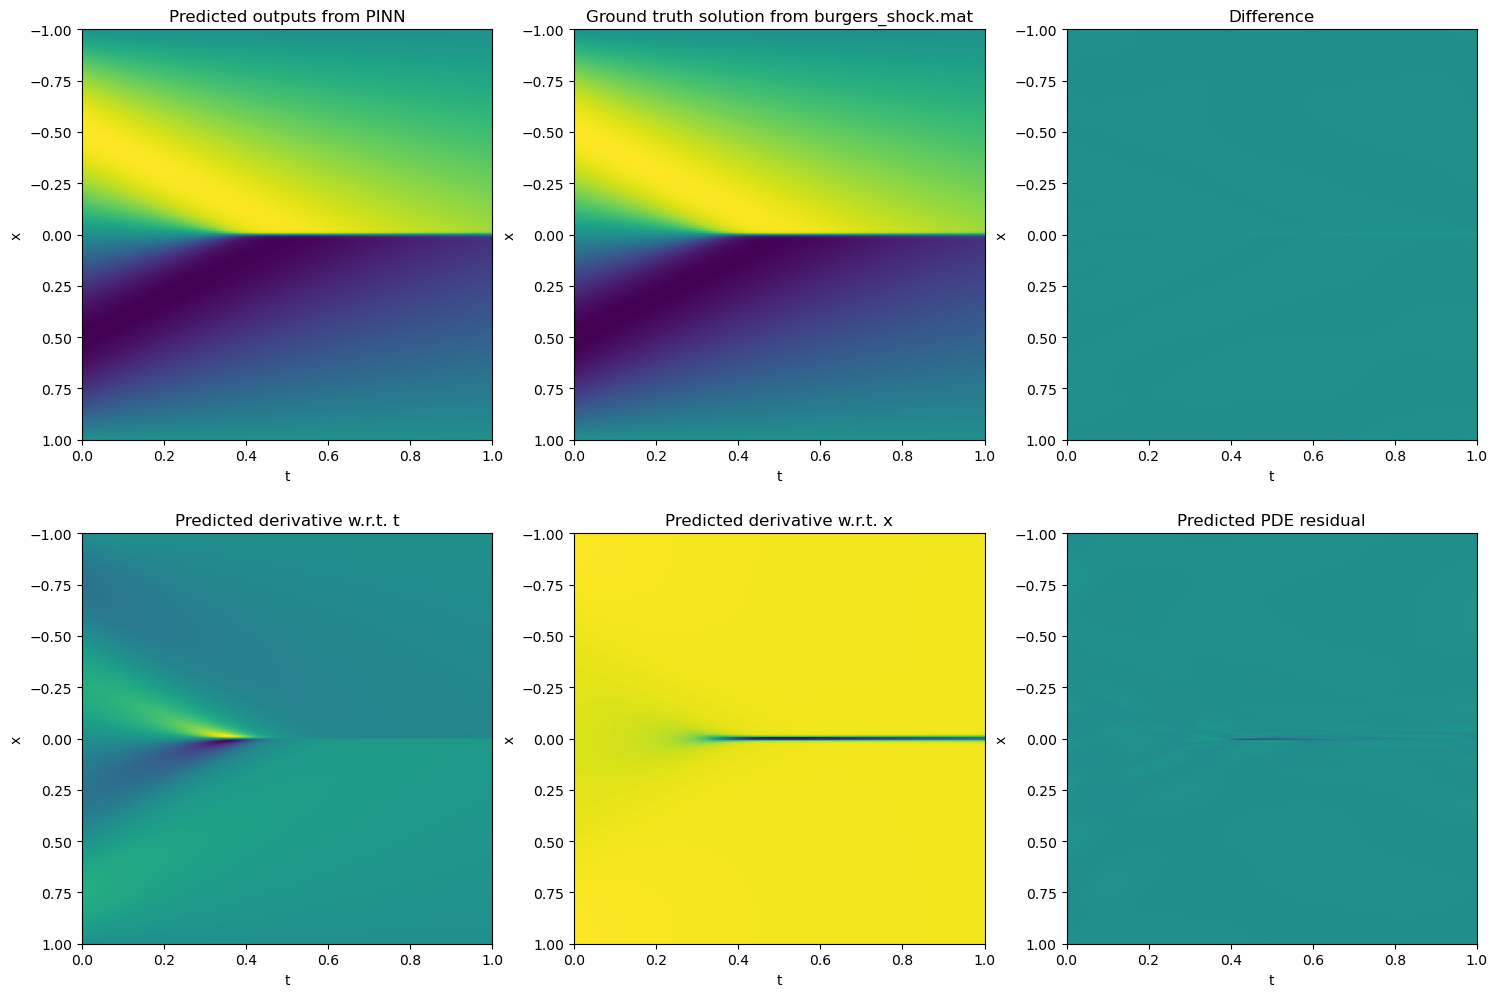

In [55]:
def plot_pinn(model):
    model.eval()

    test_output = model(grid_points)
    #     test_sample_outputs = model(sample_points)

    # Plot predictions, GT, and error over the full range
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize=(18, 12))
    outimg = test_output.cpu().detach().numpy()
    outimg = np.reshape(outimg, (xgridsize, tgridsize))

    global_min = np.min([np.min(outimg), np.min(usol_full), np.min(np.abs(outimg - usol_full))])
    global_max = np.max([np.max(outimg), np.max(usol_full), np.max(np.abs(outimg - usol_full))])

    global_max = max(abs(global_max), abs(global_min))
    global_min = -global_max
    #     global_min = -1
    #     global_max = 1

    ax1.set_title("Predicted outputs from PINN")
    ax1.set_xlabel("t")
    ax1.set_ylabel("x")
    ax1.set_box_aspect(1)
    ax1.imshow(outimg, vmin=global_min, vmax=global_max, extent=[0, 1, 1, -1], aspect='auto')

    ax2.set_title("Ground truth solution from burgers_shock.mat")
    ax2.set_xlabel("t")
    ax2.set_ylabel("x")
    ax2.set_box_aspect(1)
    ax2.imshow(usol_full, vmin=global_min, vmax=global_max, extent=[0, 1, 1, -1], aspect='auto')

    ax3.set_title("Difference")
    ax3.set_xlabel("t")
    ax3.set_ylabel("x")
    ax3.set_box_aspect(1)
    ax3.imshow(usol_full - outimg, vmin=global_min, vmax=global_max, extent=[0, 1, 1, -1], aspect='auto')

    # Calculate gradients of network
    testu_t, testu_x, testu_xx = get_grads(test_output, xv, tv)

    testres = testu_t + torch.flatten(test_output) * testu_x - 0.01 / np.pi * testu_xx

    test_ut_img = testu_t.cpu().detach().numpy()
    test_ut_img = np.reshape(test_ut_img, (xgridsize, tgridsize))
    test_ux_img = testu_x.cpu().detach().numpy()
    test_ux_img = np.reshape(test_ux_img, (xgridsize, tgridsize))
    test_res_img = testres.cpu().detach().numpy()
    test_res_img = np.reshape(test_res_img, (xgridsize, tgridsize))

    ax4.set_title("Predicted derivative w.r.t. t")
    ax4.set_xlabel("t")
    ax4.set_ylabel("x")
    ax4.set_box_aspect(1)
    ax4.imshow(test_ut_img, extent=[0, 1, 1, -1], aspect='auto')

    ax5.set_title("Predicted derivative w.r.t. x")
    ax5.set_xlabel("t")
    ax5.set_ylabel("x")
    ax5.set_box_aspect(1)
    ax5.imshow(test_ux_img, extent=[0, 1, 1, -1], aspect='auto')

    ax6.set_title("Predicted PDE residual")
    ax6.set_xlabel("t")
    ax6.set_ylabel("x")
    ax6.set_box_aspect(1)
    ax6.imshow(test_res_img, vmin=global_min, vmax=global_max, extent=[0, 1, 1, -1], aspect='auto')
    plt.show()

    #     # Plot L2 loss over full grid
    #     iter_range = np.arange(1, soln.iters+1)
    #     error = error.detach().cpu().numpy()
    #     plt.plot(iter_range, error[:soln.iters])
    #     plt.xlabel("Iteration")
    #     plt.ylabel("Relative L2 loss")
    #     plt.show()
plot_pinn(model)

In [15]:
print(test_output.min(), test_output.max())

tensor(-1.0002, device='cuda:0', dtype=torch.float64, grad_fn=<MinBackward1>) tensor(1.0001, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)


### Train Acc

### Test Acc

In [15]:
# val_loop(val_dataloader, model)

Error: 
 Accuracy: 52.6% 



52.63671875

### Feasibility

In [16]:
penalty(model, boundary_points, boundary_usol=usolb)

tensor(0.1115, device='cuda:0', dtype=torch.float64, grad_fn=<NormBackward1>)

In [17]:
l2_penalty(model, boundary_points, boundary_usol=usolb)

tensor(0.0080, device='cuda:0', dtype=torch.float64, grad_fn=<NormBackward1>)

### Graph

In [18]:
# import numpy as np
# import matplotlib.pyplot as plt

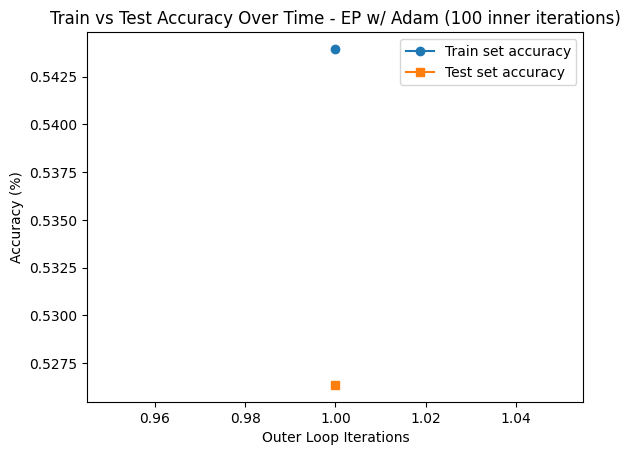

In [19]:
# # Plot results
# x = np.arange(1, len(train_acc)+1)

# plt.plot(x, train_acc, label='Train set accuracy', marker='o')
# plt.plot(x, test_acc, label='Test set accuracy', marker='s')

# plt.xlabel('Outer Loop Iterations')
# plt.ylabel('Accuracy (%)')
# plt.title('Train vs Test Accuracy Over Time - EP w/ Adam (100 inner iterations)'.format(batch_size))

# plt.legend()

# plt.show()

In [20]:
# train_acc_1000 = train_acc.copy()
# test_acc_1000 = test_acc.copy()